# [Covid-SEE](http://covid-see.cis.unimelb.edu.au/): A Scientific Evidence Explorer for COVID-19 Related Research

In this notebook we present [Covid-SEE](http://covid-see.cis.unimelb.edu.au/) -- the COVID **S**cientific **E**vidence **E**xplorer -- a system for medical literature discovery which we developed to help the medical professionals and researchers explore the literature evidence around Covid-19.

CovidSEE is different from other IR systems targeted at retrieving Covid-19 literature in several major ways:

1. In addition to the standard natural language search, we provide a more conceptual representation of relevant documents and support visual exploration of the retrieved document set.
2. We automatically identify medical concepts (based on Unified Medical Language System vocabulary) mentioned in the documents and use concepts rather than words as the core representation of the information in the documents.
3. We enable the user to explore a collection of selected articles based on the PICO scheme, often used to present the core structure of a randomised controlled trial. That is, we automatically identify **P**opulations, **I**nterventions and **O**utcomes for each of the papers. We then present a visualisation in a Sankey diagram that displays the interactions between these elements.
4. We allow the user select a set of documents they are interested in and store them in their *briefcase* (saved document collection) for further visualisation and exploration.
5. We organise the data set into *topics* derived from the medical concepts, and provide a visualisation of the active document collection in terms of topical groupings.
6. We display the most salient concepts for each of the documents in the briefcase, which allows to quickly see which articles are relevant to the user needs.
7. Last but not least, we aim to make it beautiful :)

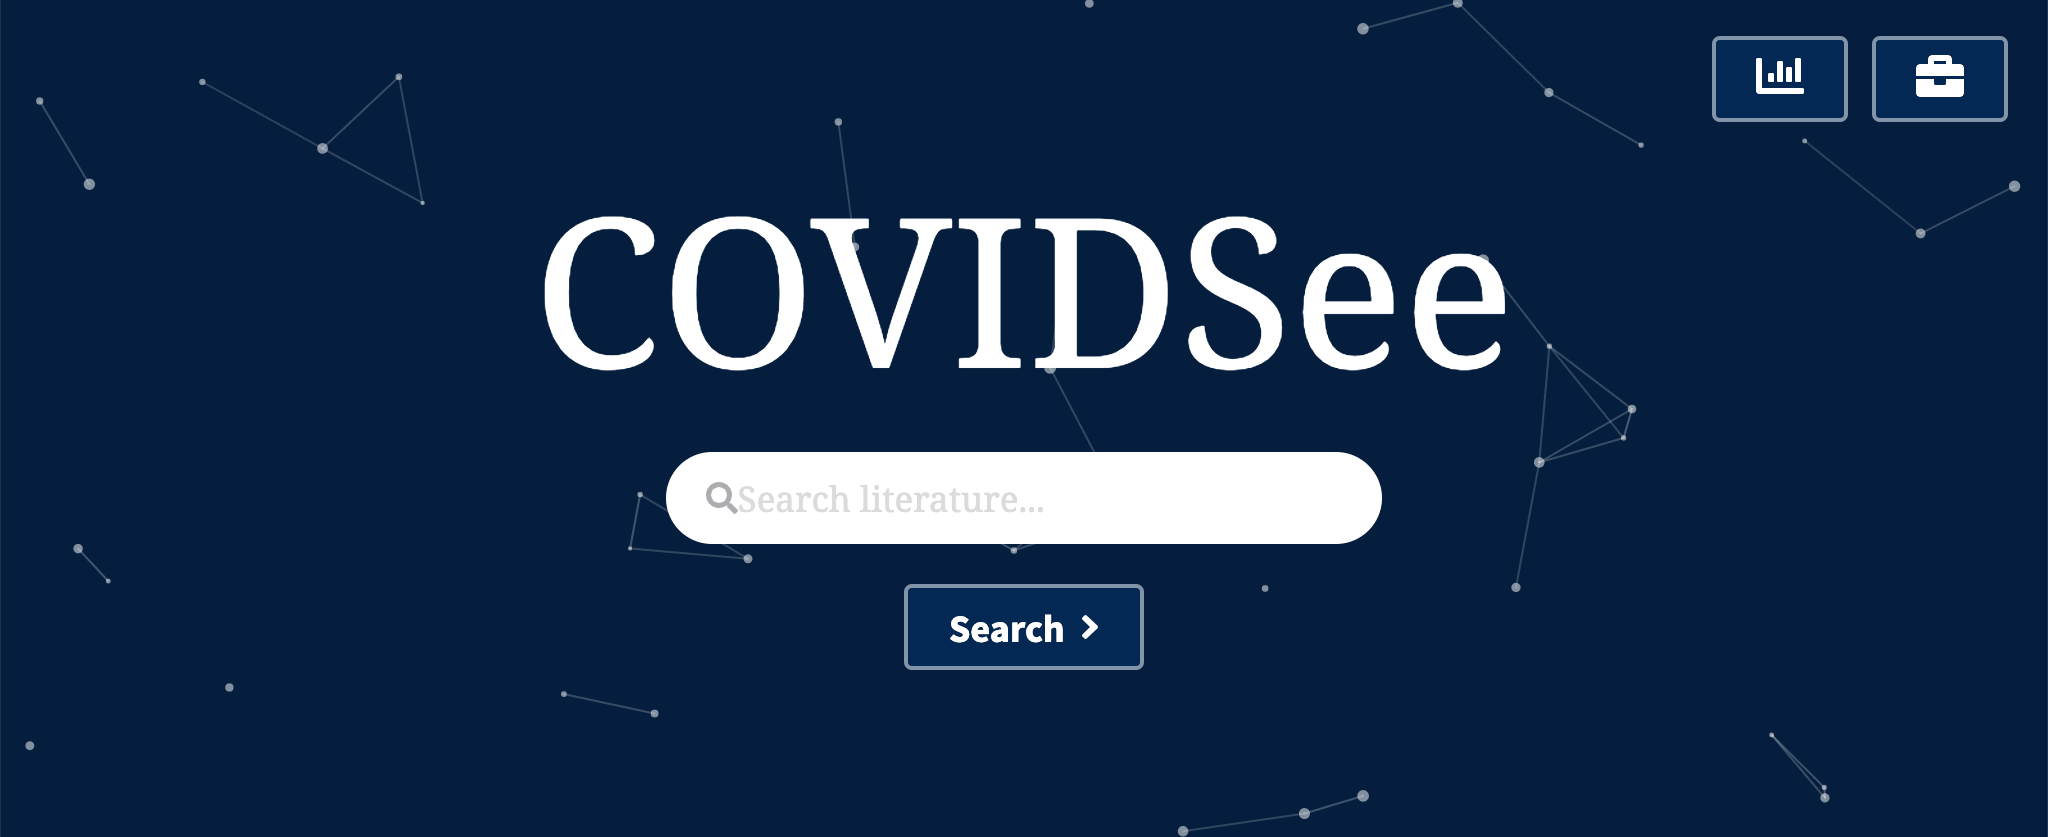


#### [System outline](#overview)
#### [Retrieving documents](#retrieve)
#### [Exploring concepts with Sankey diagrams](#sankey)
#### [Medical concept recognition](#represent)
#### [Topic modelling](#lda)
#### [Most salient concepts](#keywords)
#### [Technical details](#internals)
#### [Future extensions](#further)

<a id='overview'></a>

## System outline

The diagram below shows the general outline of the system.

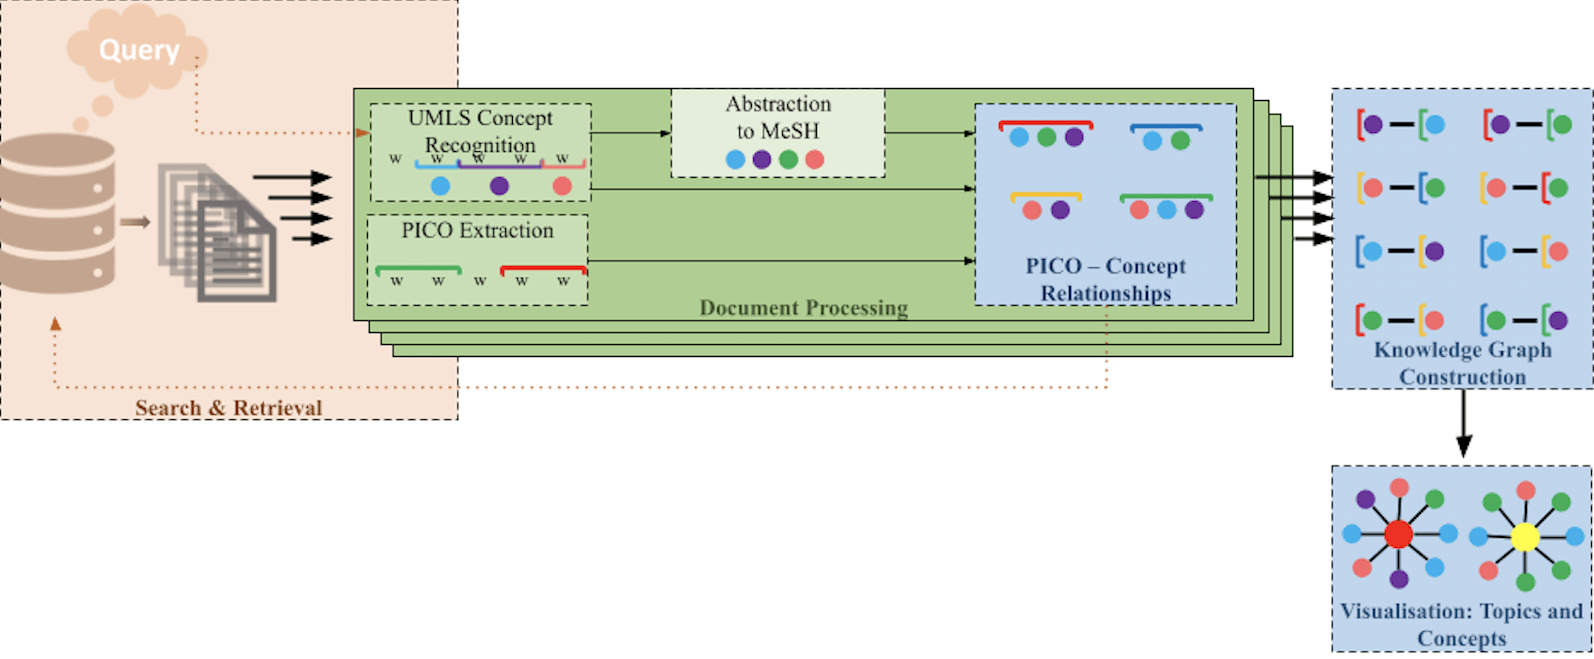

<a id='retrieve'></a>

### Retrieving documents

We make use of an existing information retrieval system for the CORD-19 dataset, developed by the team at [Covidex.ai](https://covidex.ai/). This provides us with a state-of-the-art retrieval system developed specifically for the CORD-19 dataset. We deployed the Python version of the system available in the [Covidex Github](https://github.com/castorini/covidex) and incorporated it into our Python-based web service.

The user enters a natural language query string, which is passed to the Covidex pysearch searching system. It then applies a relevancy ranking algorithm and retrieves documents relevant to the query from the CORD-19 collection. We currently cap these results to 200 documents.

For example, to explore *the range of incubation periods for Covid-19 in humans (and how this varies across age and health status) and how long individuals are contagious even after recovery*, the user enters a query in natural language such as "incubation period for COVID-19" and is presented with a typical ranked list of search results, as shown below.

The user can then select documents to add to their *briefcase* by clicking on the icon at the top left of each result. This briefcase represents the set of documents that the user wishes to keep track of. The briefcase is accessible via the icon at the top right.

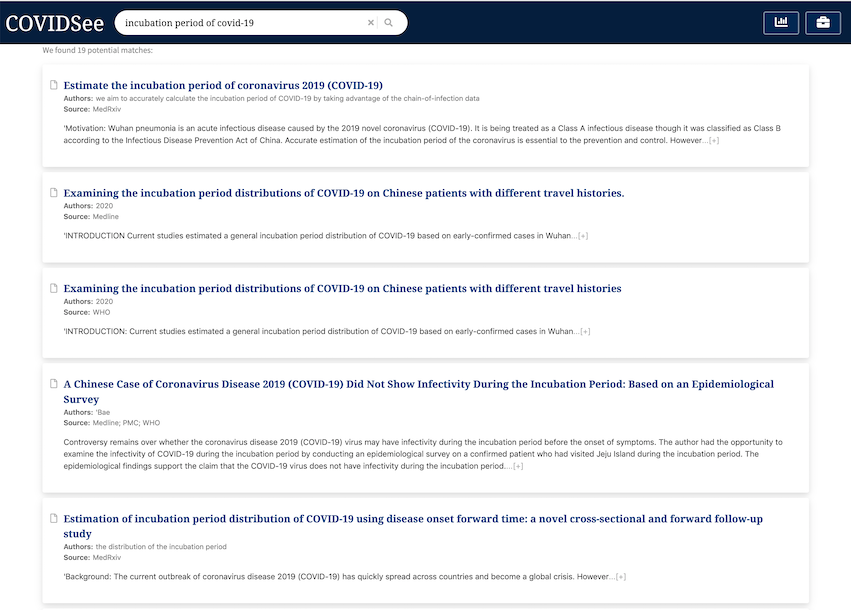


<a id='sankey'></a>

### Exploration Dashboard: Exploring PICO concepts and relationships with a Sankey diagram

With a collection of retrieved documents, the user can proceed to the Dashboard to explore that collection visually.

A key view of the collection is shown in the Sankey diagram frame. This view is based on organising identified medical concepts in each article into **Population, Intervention and Outcome categories**, and showing how they interact. The Sankey diagram represents relations between pairs of medical concepts; each relation's strength corresponds to the number of supporting articles in which that concept pair is attested. 

For instance, a document may refer to a "pediatric" Population in connection with the "incubation period" Outcome. Here the concepts of "pediatric" and "incubation" can be detected within the scope of the Population and Outcome descriptions. Thus there will be a link between "P-pediatric" and "O-incubation" in the Sankey diagram.

The user can then select a concept relation link of interest, browse the relevant articles that contain that relation, and save them to the briefcase for further exploration.

We have obtained the data for these diagrams by passing the CORD dataset through an **annotation pipeline** based on **natural language processing**:

* We detect key concept strings using the [PICO framework](https://en.wikipedia.org/wiki/PICO_process). This process identifies spans of text corresponding to either Population (Problem), Intervention and Outcome. We have labelled all CORD'19 abstracts with an [LSTM-CRF model](https://github.com/bepnye/EBM-NLP/tree/master/models/lstm-crf) trained on the [EBM-NLP dataset](https://github.com/bepnye/EBM-NLP).
* We identify [UMLS](https://www.nlm.nih.gov/research/umls/index.html) concepts with [MetaMap](https://metamap.nlm.nih.gov/), specifically, we keep the [Medical Subject Headings (MeSH)](https://www.nlm.nih.gov/mesh/meshhome.html) as our representation of concepts. The MeSH terms are standardly used for indexing and searching the medical literature, and have the advantage that they are hierarchically organized, which offers us the flexibility to tune the granularity level of the displayed information. Finally, in Sankey visualisation we only consider those concepts that occur *within* the previously identified PIO spans. 
* The result of the previous two steps are the medical concepts tied with a PIO label, e.g.: "Quarantine (**I**ntervention)", "Vital Statistics (**O**utcome)". The Sankey diagrams then display those concepts as Population-Intervention pairs and Intervention-Outcome pairs that occur within an article.

We would like to stress that the rendering of the diagrams is **dynamic**. This means that whenever a document collection selected by the user changes, the diagram is updated correspondingly. In addition, the Sankey view is "explorable", meaning that the user can click on any relation, which highlights the relevant part of the diagram and updates the necessary relation for other PIO types. A planned future release of our tool will include a functionality to use PIO-typed MeSH terms as search criteria (*semantic search*).

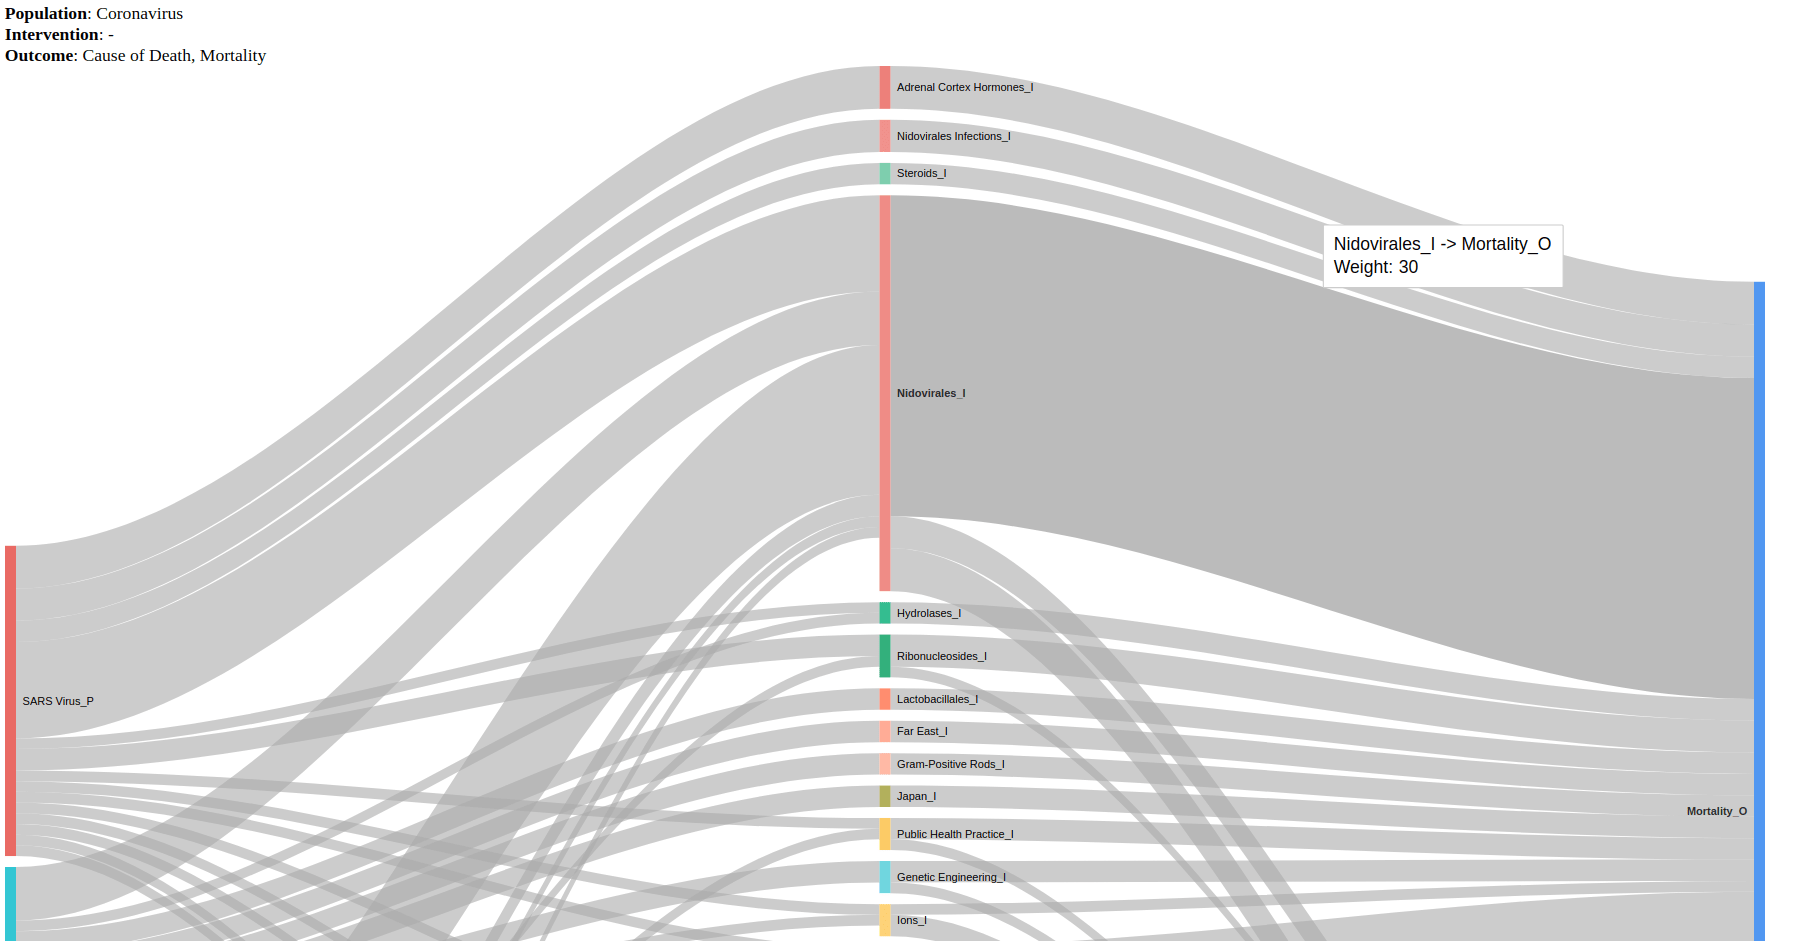

<a id='represent'></a>

### Medical concept recognition in the documents

To allow for more semantic/conceptual representation of the documents, we transform them into an unordered set of UMLS concepts. These concepts are extracted from its abstract using a Python [wrapper](https://github.com/AnthonyMRios/pymetamap/tree/master/pymetamap) for [MetaMap](http://metamap.nlm.nih.gov). If no abstract is available, we use the section named Introduction or, if it is not present, the first two paragraphs. 

To use one of the articles retrieved in the example above, the abstract `wuhan pneumonia is an acute infectious disease caused by the 2019 novel coronavirus for hubei province...` is represented as a list of concept identifiers `C0032285 C0275518 C0015127 C0205314...`. This helps not only to avoid splitting multi-word concepts (such as *acute infectious disease*) into less meaningful units (as would happen if we used space-separated tokens), but also to map several lexical and grammatical variations of a term to a single concept and thus reduce noise in the data, highlighting important keywords. For example, a concept C0000731 is represented in the articles using such variations as *abdominal distension*, *abdominal distention*, *bloating*, *distended abdomens*, *swelling of abdomen* etc. which would not be captured by typical approaches to text normalisation such as lemmatisation, stemming or bigram representations. Then we map each concept identifier to its most common representation in the CORD dataset to normalize terms. An alternative approach would be to use the "Preferred term" suggested by the MetaMap, but as it is often a technical description of a term rather than its lexical form, we found that utilising the most commonly used lexical form for the visualisation works better from the user perspective. 

As the last step, we remove stopwords based on PubMed's [stopword list](https://www.ncbi.nlm.nih.gov/books/NBK3827/table/pubmedhelp.T.stopwords/) and 100 most frequent token in the dataset.

This representation forms the foundation of the remaining analysis and visualisations.

<a id='lda'></a>

### Exploration Dashboard: Topic Models

We provide a visualisation based on "topic" or thematic analysis of the dataset, in which documents that have shared content/themes are clustered together.  This view allows for more thematic exploration of the current focus collection of documents.

We use Latent Dirichlet Allocation (LDA) to learn the topics in the whole dataset and then represent topics for a particular subset of articles (the briefcase) as a 2-dimensional map using principal component analysis (PCA) from [pyLDAvis](https://github.com/bmabey/pyLDAvis/tree/master/pyLDAvis) package. LDA represents each document as a mixture of topics, and each word in a document has weights corresponding to one or more topics. We learn 100 topics for the whole dataset, and then display only those which are representative enough for the selected subset, that is, the ones for which the sum of topic weights across the selected documents is over the threshold t = λ*L, where L is the number of selected documents and λ is a hyperparameter which we set to 0.01. Thus, the topic representation is different for each set of selected documents, and it is easier to see what are they about.

The example below shows topic models which were learned for the 5 first documents retrieved by the query above. Note the inclusion of meaningful concepts, rather than simply individual words, in the set of terms representing a topic.

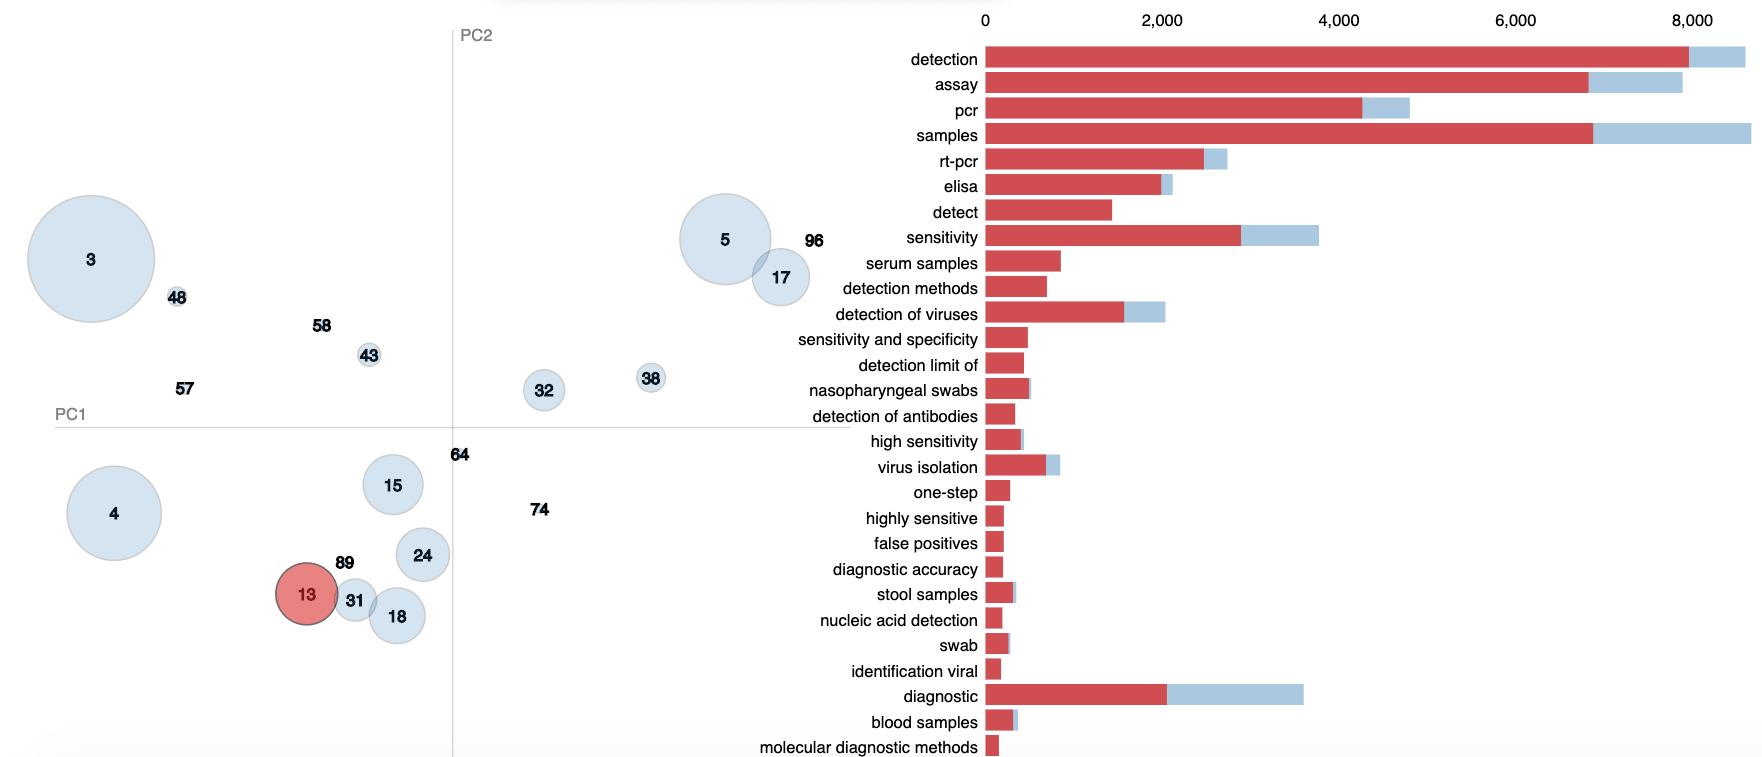

<a id='keywords'></a>

### Exploration Dashboard: Representing most salient concepts

For each of the selected documents we display a [wordcloud](http://amueller.github.io/word_cloud/). Wordclouds are commonly used to visualize the content of texts, but they are not very informative in their usual use case, that is, when they display top-N most common words in the document. When selecting top-N common words or top-N TF-IDF scores, the wordclouds tended to consist of such common words as "China" or "infections" and it was impossible to see how each document differed from the others. To avoid this, we used a saliency score based on log-likelihood to compare the frequency of each term in the document with its frequency in all other documents in the briefcase. To avoid zero division for terms not present in other documents we use Laplace smoothing. Below is an example of a wordcloud for one of the documents in our briefcase:

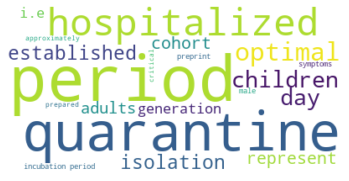



<a id='internals'></a>

### Technical details

For seamless integration of our source data and annotations, all data is stored in a graph database ([neo4j](https://neo4j.com/)). The front end of our web application then interacts with the database by querying it using the [Cypher](https://neo4j.com/developer/cypher-query-language/) language and the [py2neo](https://py2neo.org/) library.

The website was built with [React](https://reactjs.org/) and the [Flask web development framework](https://flask.palletsprojects.com/en/1.1.x/), and visualisations are supported by [D3](https://d3js.org/ ) and [PyLDAVis](https://github.com/bmabey/pyLDAvis) for the topic model visualisation. Core analysis was done in Python.

<a id='further'></a>

### Future Extensions of COVID-SEE

As mentioned above, we plan to allow *semantic search* in a future extension of the current system, building on the PICO framework and the UMLS vocabulary, similar to the [COVID-19 Navigator](https://covid-19-navigator.mybluemix.net/) system from IBM. This is straightforwardly supported by the pre-processing we are performing over the articles.

We will experiment with expanding beyond the MeSH term vocabulary to include more specific terminology such as drug names or clinical symptoms.

We also plan to explore how to make better use of the hierarchical relationships that exist between terms in our visualisation.